In [3]:
import os, os.path
import glob
import pickle
import numpy
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import pal5_util_old as pal5_util
from gd1_util import R0, V0
import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot


Populating the interactive namespace from numpy and matplotlib


In [4]:
#define functions
def galcencyl_to_lbd(R,phi,Z,degree=True):
        xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
        l=[]
        b=[]
        d=[]
        for ii in range(len(xyz)):
            lbd=bovy_coords.XYZ_to_lbd(xyz[ii][0],xyz[ii][1],xyz[ii][2],degree=degree)
            l.append(lbd[0])
            b.append(lbd[1])
            d.append(lbd[2])
            
        return (l,b,d)
                     

def compute_Pk(filename, scaling = 'spectrum'):
    data= numpy.loadtxt(filename)
    p1=data[:,0][4:]
    tdata=data[:,1][4:]
    data_err=data[:,2][4:]
    
    #print (p1)
    
    
    px,py= signal.csd(tdata,tdata,fs=1./(p1[1]-p1[0]),scaling=scaling,nperseg=len(p1))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(p1[-1]-p1[0]))
    
            
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err= numpy.empty((nerrsim,len(px)))
    for ii in range(nerrsim):
        tmock= data_err*numpy.random.normal(size=len(p1))
        ppy_err[ii]= signal.csd(tmock,tmock,
                                fs=1./(p1[1]-p1[0]),scaling=scaling,
                                nperseg=len(p1))[1].real
    py_err= numpy.sqrt(numpy.median(ppy_err,axis=0)*(p1[-1]-p1[0]))
    
    #return 180./px/numpy.pi, py, py_err #if apars
    return px, py, py_err




def set_ranges_and_labels_dens():
    bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$',size=18)
    ylim(0.001,10.)
    xlim(1,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None

def set_ranges_and_labels_dens_1():
    #bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$',size=18)
    ylim(0.0008,10.)
    xlim(1,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None


def process_sample(N,dir_trail,out_format='radec'):
    #dir_trail contains all the sample files from the trailing arm
    #convert R,z,phi to ra,dec to xi, eta
    dir_lead = dir_trail.replace('trailing','leading')
    allfname_trail= glob.glob(dir_trail + '*.dat')
    allfname_lead= glob.glob(dir_lead + '*.dat')
    R_t=[]
    phi_t=[]
    z_t=[]
    vR_t=[]
    vT_t=[]
    vz_t=[]
    t_t=[]

    R_l=[]
    phi_l=[]
    z_l=[]
    vR_l=[]
    vT_l=[]
    vz_l=[]
    t_l=[]
     
    for i in range(N):
    #for i in range(10):
        try :
            R_t.append(numpy.loadtxt(allfname_trail[i])[:,0])
            phi_t.append(numpy.loadtxt(allfname_trail[i])[:,1])
            z_t.append(numpy.loadtxt(allfname_trail[i])[:,2])
            vR_t.append(numpy.loadtxt(allfname_trail[i])[:,3])
            vT_t.append(numpy.loadtxt(allfname_trail[i])[:,4])
            vz_t.append(numpy.loadtxt(allfname_trail[i])[:,5])
            t_t.append(numpy.loadtxt(allfname_trail[i])[:,6])
            
        except ValueError : 
            print (allfname_trail[i])
        
    for ii in range(N):
    #for ii in range(10): 
        try :
            R_l.append(numpy.loadtxt(allfname_lead[ii])[:,0])
            phi_l.append(numpy.loadtxt(allfname_lead[ii])[:,1])
            z_l.append(numpy.loadtxt(allfname_lead[ii])[:,2])
            vR_l.append(numpy.loadtxt(allfname_lead[ii])[:,3])
            vT_l.append(numpy.loadtxt(allfname_lead[ii])[:,4])
            vz_l.append(numpy.loadtxt(allfname_lead[ii])[:,5])
            t_l.append(numpy.loadtxt(allfname_lead[ii])[:,6])
            
        except ValueError : 
            print (allfname_lead[ii])
        
    Rall_t = np.array([item for sublist in R_t for item in sublist])
    phiall_t = np.array([item for sublist in phi_t for item in sublist])
    zall_t = np.array([item for sublist in z_t for item in sublist])
    vRall_t = np.array([item for sublist in vR_t for item in sublist])
    vTall_t = np.array([item for sublist in vT_t for item in sublist])
    vzall_t = np.array([item for sublist in vz_t for item in sublist])
    tall_t = np.array([item for sublist in t_t for item in sublist])

    Rall_l = np.array([item for sublist in R_l for item in sublist])
    phiall_l = np.array([item for sublist in phi_l for item in sublist])
    zall_l = np.array([item for sublist in z_l for item in sublist])
    vRall_l = np.array([item for sublist in vR_l for item in sublist])
    vTall_l = np.array([item for sublist in vT_l for item in sublist])
    vzall_l = np.array([item for sublist in vz_l for item in sublist])
    tall_l = np.array([item for sublist in t_l for item in sublist])
    
    x_l,y_l,z_l=bovy_coords.cyl_to_rect(Rall_l,phiall_l,zall_l)
    
    l_t,b_t,d_t=np.array(galcencyl_to_lbd(Rall_t,phiall_t,zall_t))
    l_l,b_l,d_l=np.array(galcencyl_to_lbd(Rall_l,phiall_l,zall_l))
    
    radec_t=bovy_coords.lb_to_radec(l_t,b_t,degree=True) 
    radec_l=bovy_coords.lb_to_radec(l_l,b_l,degree=True)
    
    o_t=[]
    ts_t=[]
    o_l=[]
    ts_l=[]
    
   
    if out_format=='radec' :
        return (radec_t[:,0],radec_t[:,1],radec_l[:,0],radec_l[:,1])
    
    elif out_format=='xieta':
        
        mxieta_t= pal5_util.radec_to_pal5xieta(radec_t[:,0],radec_t[:,1],degree=True)
        xi_t= mxieta_t[:,0]
        eta_t=mxieta_t[:,1]

        mxieta_l= pal5_util.radec_to_pal5xieta(radec_l[:,0],radec_l[:,1],degree=True)
        xi_l= mxieta_l[:,0]
        eta_l=mxieta_l[:,1]
    
        return (xi_t,eta_t,xi_l,eta_l)
        
        
    else : 
        print ("acceptable output format : radec or xieta")
        

def include_both_arms(xi_t,eta_t,xi_l,eta_l):
    min_eta_t=min(eta_t)
    max_eta_t=max(eta_t)

    xi_l_select=[]
    eta_l_select=[]

    for jj in range(len(eta_l)):
        if min_eta_t <= eta_l[jj] <= max_eta_t :
            xi_l_select.append(xi_l[jj])
            eta_l_select.append(eta_l[jj])

    print (len(xi_l), len(xi_l_select))

       
    xi_all = np.concatenate((xi_t,xi_l_select))
    
    return xi_all


  

In [23]:
#smooth stream
dir='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_streamdf_nobarpot/trailing/'
sxi_t,seta_t,sxi_l,seta_l=process_sample(500,dir,out_format='xieta')

sxi_both_arms=include_both_arms(sxi_t,seta_t,sxi_l,seta_l)

500000 81414


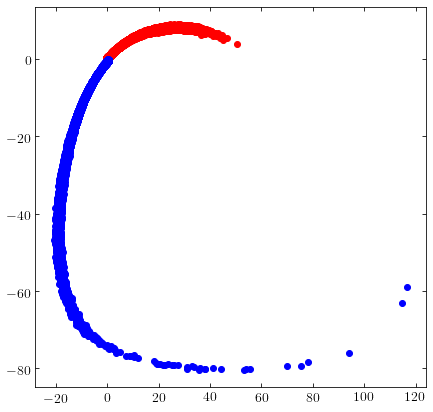

In [104]:
plt.figure()
plt.scatter(sxi_t,seta_t,c='r')
plt.scatter(sxi_l,seta_l,c='b')
plt.show()

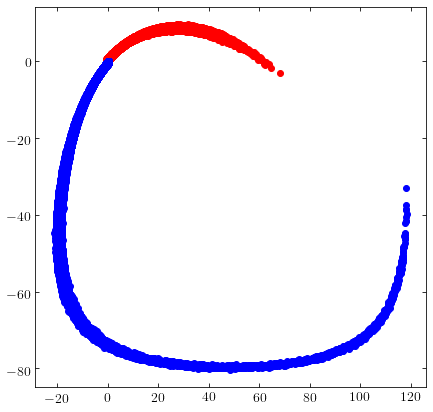

In [101]:
plt.figure()
plt.scatter(sxi_t,seta_t,c='r')
plt.scatter(sxi_l,seta_l,c='b')
plt.show()

In [26]:
#perturbed stream
dir1='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_39patspeed_streamdf/trailing/'
xi_t,eta_t,xi_l,eta_l=process_sample(1000,dir1,out_format='xieta')

xi_both_arms=include_both_arms(xi_t,eta_t,xi_l,eta_l)

550500 289970


In [5]:
def compute_ndenxi(xi,minxi=0.25,maxxi=14.35,bw=0.1,polydeg=3):
    N=len(xi)
    print (N)
    minxi = minxi
    maxxi= maxxi
    bw= bw

    nbins= (maxxi - minxi)/bw
    print ("no of xi bins = %i"%nbins)

    xibin_edge=[(minxi-0.5*bw) + i*bw for i in range(int(nbins)+2)]
    #print (xibin_edge)
    midxi=[0.5*(xibin_edge[i] + xibin_edge[i+1]) for i in range(int(nbins)+1)]
    
    Ndn=np.histogram(xi,xibin_edge)[0]
    print (np.sum(Ndn))
    Ndn_err=numpy.sqrt(Ndn)
       
    pp= Polynomial.fit(midxi,Ndn,deg=polydeg,w=1/(Ndn_err))
    nden=Ndn/pp(np.array(midxi))
    nden_err=np.sqrt(Ndn)/pp(np.array(midxi))
        
    
    return (midxi,Ndn,Ndn_err,nden,nden_err,pp(np.array(midxi)))


In [25]:
smidxi,sNdn,sNdn_err,_,_,_ = compute_ndenxi(sxi_both_arms,minxi=0.65)

581414
no of xi bins = 136
275548


In [27]:
midxi,Ndn,Ndn_err,nden,nden_err,pp = compute_ndenxi(xi_both_arms,minxi=0.65)

840470
no of xi bins = 136
309307


In [13]:
outdir=dir1.replace('trailing','')
fo=open(outdir + 'Pal5_density_botharms_1mil_1010Msun_streamdf_5Gyr_39patspeed_poly3norm.dat','w')
fo.write("#xi    den_contrast    shot_noise" + '\n')
for jj in range(len(nden)):
    fo.write(str(midxi[jj]) + "   " + str(nden[jj]) + "   " + str(nden_err[jj]) + "\n")

fo.close()

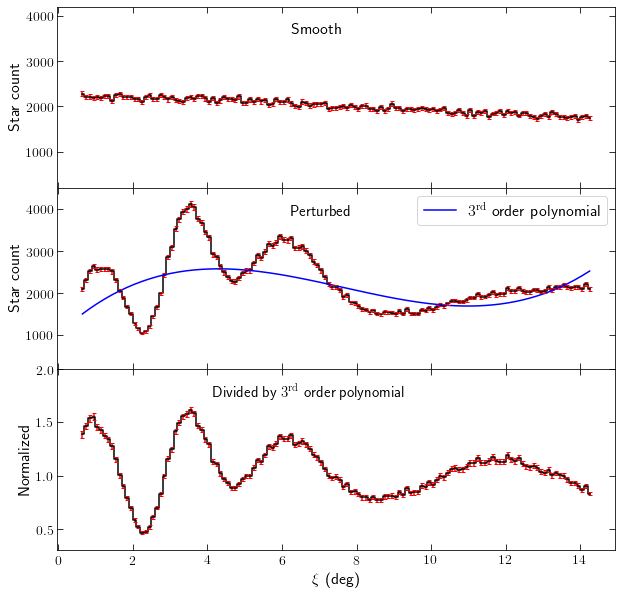

In [32]:
#bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
#figsize(7,9)

plt.figure(figsize=(10,10))
ax1=plt.subplot(3,1,1)

ax1.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.,labelbottom=False) 
plt.plot(smidxi,sNdn,c='k',ls='steps-mid')
plt.errorbar(smidxi,sNdn,sNdn_err,marker='None',ls='None',capsize=2.,ecolor='r')
plt.ylabel('Star count',fontsize=16)
plt.text(0.42,0.85,'Smooth',fontsize=16,transform=ax1.transAxes)
plt.ylim(200,4200)
plt.xlabel([])
plt.xtick_labelsize=0.

ax2=plt.subplot(3,1,2)
ax2.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.,labelbottom=False) 
plt.plot(midxi,Ndn,ls='steps-mid',c='k')
plt.text(0.42,0.85,'Perturbed',fontsize=15,transform=ax2.transAxes)
plt.plot(midxi,pp,c='b',label=r'$3^{\rm{rd}}$ order polynomial')
plt.errorbar(midxi,Ndn,Ndn_err,marker='None',ls='None',capsize=2.,ecolor='r')
plt.ylim(200,4500)
plt.xlabel([])
#plt.xticks([])
plt.ylabel('Star count',fontsize=16)
plt.legend(loc='upper right',fontsize=16)

ax3=plt.subplot(3,1,3)
ax3.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.) 
plt.plot(midxi,nden,ls='steps-mid',c='k')
plt.text(0.28,0.85,r'Divided by $3^{\rm{rd}}$ order polynomial',fontsize=15,transform=ax3.transAxes)
plt.errorbar(midxi,nden,nden_err,marker='None',capsize=2.,ls='None',ecolor='r')
plt.ylim(0.3,2.0)
#plt.xlim(0.2,15.)
plt.xlabel(r'$\xi$ (deg)',fontsize=16)
plt.ylabel('Normalized',fontsize=16)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('plots/nden_1010Msun_streamdf_patspeed39.pdf')
plt.show()
            

In [46]:
#perturbed stream
method = 'spraydf'
pspeed=[39,43,47,51,57,61]

for p in pspeed :
    print (p)
    dir1='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_{}patspeed_{}/trailing/'.format(p,method)
    xi_t,eta_t,xi_l,eta_l=process_sample(900,dir1,out_format='xieta')
    print (len(xi_t))
    xi_both_arms=include_both_arms(xi_t,eta_t,xi_l,eta_l)[:500000]
    print ('number %i'%len(xi_both_arms))
    midxi,Ndn,Ndn_err,nden,nden_err,pp = compute_ndenxi(xi_both_arms)
    
    outdir=dir1.replace('trailing','')
    fo=open(outdir + 'Pal5_density_botharms_1010Msun_{}_5Gyr_{}patspeed_poly3norm.dat'.format(method,p),'w')
    fo.write("#xi    den_contrast    shot_noise" + '\n')
    for jj in range(len(nden)):
        fo.write(str(midxi[jj]) + "   " + str(nden[jj]) + "   " + str(nden_err[jj]) + "\n")

    fo.close()
    


39
500500
500500 496001
number 500000
500000
no of xi bins = 141
433078
43
500500
500500 496824
number 500000
500000
no of xi bins = 141
380474
47
500500
500500 492497
number 500000
500000
no of xi bins = 141
375881
51
500500
500500 475364
number 500000
500000
no of xi bins = 141
403935
57
450000
450000 375011
number 500000
500000
no of xi bins = 141
344701
61
450000
450000 438943
number 500000
500000
no of xi bins = 141
337797


/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide



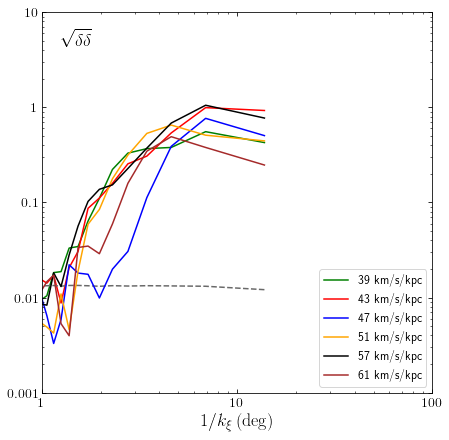

In [35]:
method = 'streamdf'

dir2='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/'
fname0=dir2 + '1010Msun_39patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(method,method)
fname1=dir2 + '1010Msun_43patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_43patspeed_poly3norm.dat'.format(method,method)
fname2=dir2 + '1010Msun_47patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_47patspeed_poly3norm.dat'.format(method,method)
fname3=dir2 + '1010Msun_51patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_51patspeed_poly3norm.dat'.format(method,method)
fname4=dir2 + '1010Msun_57patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_57patspeed_poly3norm.dat'.format(method,method)
fname5=dir2 + '1010Msun_61patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_61patspeed_poly3norm.dat'.format(method,method)


px0,py0,pyerr0=compute_Pk(fname0, scaling = 'spectrum')
px1,py1,pyerr1=compute_Pk(fname1, scaling = 'spectrum')
px2,py2,pyerr2=compute_Pk(fname2, scaling = 'spectrum')
px3,py3,pyerr3=compute_Pk(fname3, scaling = 'spectrum')
px4,py4,pyerr4=compute_Pk(fname4, scaling = 'spectrum')
px5,py5,pyerr5=compute_Pk(fname5, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)


loglog(px0,py0,color='g',zorder=1,label=r'39 km/s/kpc')
#loglog(px0,pyerr0,color='g',ls='--',zorder=1)
loglog(px1,py1,color='r',zorder=1,label=r'43 km/s/kpc')
loglog(px0,pyerr1,color='dimgray',ls='--',zorder=1)
loglog(px2,py2,color='b',zorder=1,label=r'47 km/s/kpc')
#loglog(px0,pyerr2,color='b',ls='--',zorder=1)
loglog(px3,py3,color='orange',zorder=1,label=r'51 km/s/kpc')
#loglog(px0,pyerr3,color='orange',ls='--',zorder=1)
loglog(px4,py4,color='k',zorder=1,label=r'57 km/s/kpc')
#loglog(px0,pyerr4,color='k',ls='--',zorder=1)
loglog(px5,py5,color='brown',zorder=1,label=r'61 km/s/kpc')
#loglog(px0,pyerr5,color='brown',ls='--',zorder=1)
#loglog(px,pyerr,lw=2.,color='k',zorder=1,ls='--')
legend(loc='lower right')

set_ranges_and_labels_dens()
#savefig('plots/power_1mil39_patspeed_streamdf_5Gyrbarpot.pdf')

In [7]:
method = 'spraydf'

spdir2='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/'
spfname0=spdir2 + '1010Msun_39patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(method,method)
spfname1=spdir2 + '1010Msun_43patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_43patspeed_poly3norm.dat'.format(method,method)
spfname2=spdir2 + '1010Msun_47patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_47patspeed_poly3norm.dat'.format(method,method)
spfname3=spdir2 + '1010Msun_51patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_51patspeed_poly3norm.dat'.format(method,method)
spfname4=spdir2 + '1010Msun_57patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_57patspeed_poly3norm.dat'.format(method,method)
spfname5=spdir2 + '1010Msun_61patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_61patspeed_poly3norm.dat'.format(method,method)


sppx0,sppy0,sppyerr=compute_Pk(spfname0, scaling = 'spectrum')
sppx1,sppy1,sppyerr=compute_Pk(spfname1, scaling = 'spectrum')
sppx2,sppy2,sppyerr=compute_Pk(spfname2, scaling = 'spectrum')
sppx3,sppy3,sppyerr=compute_Pk(spfname3, scaling = 'spectrum')
sppx4,sppy4,sppyerr=compute_Pk(spfname4, scaling = 'spectrum')
sppx5,sppy5,sppyerr=compute_Pk(spfname5, scaling = 'spectrum')

method = 'spraydf_noprog'

spnpdir2='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/'
spnpfname0=spnpdir2 + '1010Msun_39patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(method,method)
spnpfname1=spnpdir2 + '1010Msun_43patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_43patspeed_poly3norm.dat'.format(method,method)
spnpfname2=spnpdir2 + '1010Msun_47patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_47patspeed_poly3norm.dat'.format(method,method)
spnpfname3=spnpdir2 + '1010Msun_51patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_51patspeed_poly3norm.dat'.format(method,method)
spnpfname4=spnpdir2 + '1010Msun_57patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_57patspeed_poly3norm.dat'.format(method,method)
spnpfname5=spnpdir2 + '1010Msun_61patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_61patspeed_poly3norm.dat'.format(method,method)

spnppx0,spnppy0,spnppyerr=compute_Pk(spnpfname0, scaling = 'spectrum')
spnppx1,spnppy1,spnppyerr=compute_Pk(spnpfname1, scaling = 'spectrum')
spnppx2,spnppy2,spnppyerr=compute_Pk(spnpfname2, scaling = 'spectrum')
spnppx3,spnppy3,spnppyerr=compute_Pk(spnpfname3, scaling = 'spectrum')
spnppx4,spnppy4,spnppyerr=compute_Pk(spnpfname4, scaling = 'spectrum')
spnppx5,spnppy5,spnppyerr=compute_Pk(spnpfname5, scaling = 'spectrum')

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide



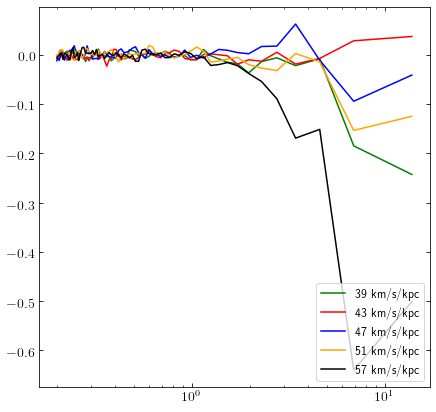

In [8]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

semilogx(sppx0,sppy0-spnppy0,color='g',zorder=1,label=r'39 km/s/kpc')
semilogx(sppx1,sppy1-spnppy1,color='r',zorder=1,label=r'43 km/s/kpc')
semilogx(sppx2,sppy2-spnppy2,color='b',zorder=1,label=r'47 km/s/kpc')
semilogx(sppx3,sppy3-spnppy3,color='orange',zorder=1,label=r'51 km/s/kpc')
semilogx(sppx4,sppy4-spnppy4,color='k',zorder=1,label=r'57 km/s/kpc')
legend(loc='lower right')

#set_ranges_and_labels_dens()
#savefig('plots/power_spraydf_noprog_5Gyrbarpot.pdf')

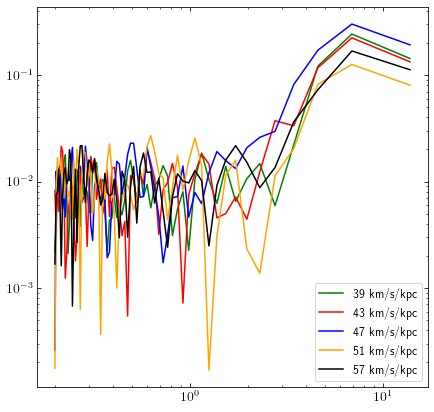

In [9]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

loglog(sppx0,sppy0,color='g',zorder=1,label=r'39 km/s/kpc')
loglog(sppx1,sppy1,color='r',zorder=1,label=r'43 km/s/kpc')
loglog(sppx2,sppy2,color='b',zorder=1,label=r'47 km/s/kpc')
loglog(sppx3,sppy3,color='orange',zorder=1,label=r'51 km/s/kpc')
loglog(sppx4,sppy4,color='k',zorder=1,label=r'57 km/s/kpc')
legend(loc='lower right')

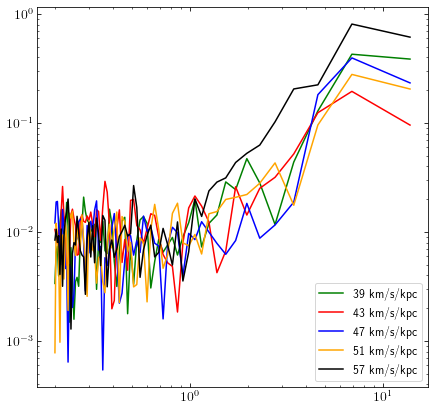

In [10]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

loglog(sppx0,spnppy0,color='g',zorder=1,label=r'39 km/s/kpc')
loglog(sppx1,spnppy1,color='r',zorder=1,label=r'43 km/s/kpc')
loglog(sppx2,spnppy2,color='b',zorder=1,label=r'47 km/s/kpc')
loglog(sppx3,spnppy3,color='orange',zorder=1,label=r'51 km/s/kpc')
loglog(sppx4,spnppy4,color='k',zorder=1,label=r'57 km/s/kpc')
legend(loc='lower right')

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in true_divide



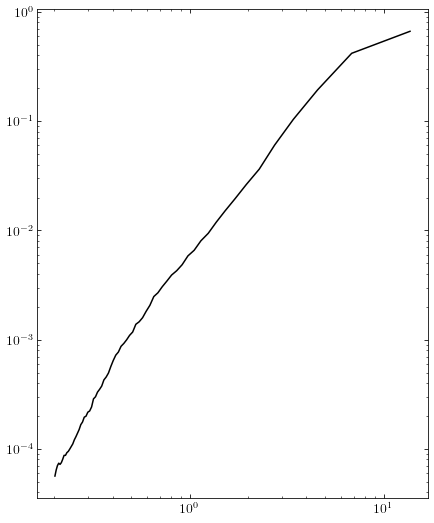

In [11]:
## Code to plot the power spectrum of the CDM Plummer case to compare power with the GMCs

with open('../GMC/pkl_files/pal5pepper_64sampling_MW2014.pkl','rb') as savefile:
                sdf_smooth= pickle.load(savefile,encoding='latin1')
                sdf_pepper= pickle.load(savefile,encoding='latin1')

import pal5_util_old as pal5_util
def convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    mxieta= pal5_util.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    outll= numpy.arange(0.65,14.35,0.1)
    # Interpolate density
    ipll= interpolate.InterpolatedUnivariateSpline(mxieta[:,0],apars)
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    return (outll,ipdens(ipll(outll)))


bfilename= 'Pal5_CDM/'
filename = bfilename + 'Pal5_t64sampling_CDM_X10_5-9_dens_all.dat'
mOfilename= filename.replace('dens','omega')

densdata= numpy.genfromtxt(filename,delimiter=',',max_rows=5002)
Om_data= numpy.genfromtxt(mOfilename,delimiter=',',max_rows=5002)

apars= densdata[0]
dens_smooth=densdata[1]
ll=[]
densll=[]

mO=Om_data[2]

ll=convert_dens_to_obs(apars,densdata[2],dens_smooth,mO,poly_deg=3)[0]
densll=convert_dens_to_obs(apars,densdata[2],dens_smooth,mO,poly_deg=3)[1]

px,py= signal.csd(densll,densll,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))
py= py.real
ppy= numpy.empty((len(densdata)-2,len(px)))
ppy[0]=py


for ii in range(len(densdata)-2):
    try :
    
        mO=Om_data[2+ii]
        dens=densdata[2+ii]
        ll=convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3)[0]
        densll=convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3)[1]
                        
        ppy[ii]= signal.csd(densll,densll,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))[1].real
    
    except ValueError :
        print (ii)
        
        
        
Ppy=numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0]))
Px=1./px

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,9)
 
loglog(Px,Ppy,color='k',zorder=1)
#set_ranges_and_labels_dens()
#savefig('Power_Plummer_6-9_CDM.pdf')

In [117]:
## Code to plot the power spectrum of the CDM Plummer case to compare power with the GMCs

bfilename= '../streamdata/pal5_multtime/fromJo/'
filename = bfilename + 'pal5_t64sampling_X10_6-9_dens.dat'
mOfilename= filename.replace('dens','omega')

densdata= numpy.genfromtxt(filename,delimiter=',',max_rows=5002)
Om_data= numpy.genfromtxt(mOfilename,delimiter=',',max_rows=5002)

apars= densdata[0]
dens_smooth=densdata[1]
ll=[]
densll=[]

mO=Om_data[2]

ll=convert_dens_to_obs(apars,densdata[2],dens_smooth,mO,poly_deg=3)[0]
densll=convert_dens_to_obs(apars,densdata[2],dens_smooth,mO,poly_deg=3)[1]

px1,py1= signal.csd(densll,densll,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))
py1= py1.real
ppy1= numpy.empty((len(densdata)-2,len(px1)))
ppy1[0]=py1


for ii in range(len(densdata)-2):
    try :
    
        mO=Om_data[2+ii]
        dens=densdata[2+ii]
        ll=convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3)[0]
        densll=convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3)[1]
                        
        ppy1[ii]= signal.csd(densll,densll,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))[1].real
    
    except ValueError :
        print (ii)
        
        
        
Ppy1=numpy.sqrt(numpy.nanmedian(ppy1,axis=0)*(ll[-1]-ll[0]))
Px1=1./px1

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide



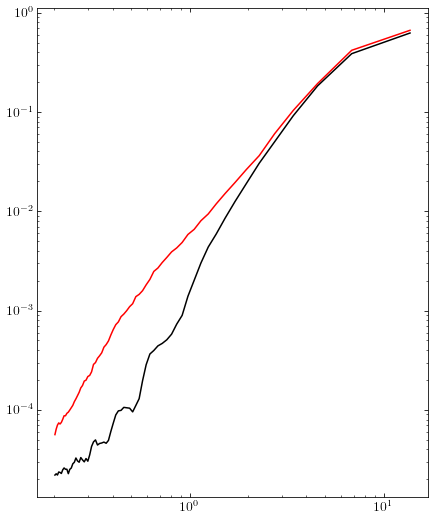

In [118]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,9)
 
loglog(Px,Ppy,color='r',zorder=1)
loglog(Px1,Ppy1,color='k',zorder=1)
#set_ranges_and_labels_dens()
#savefig('Power_Plummer_6-9_CDM.pdf')

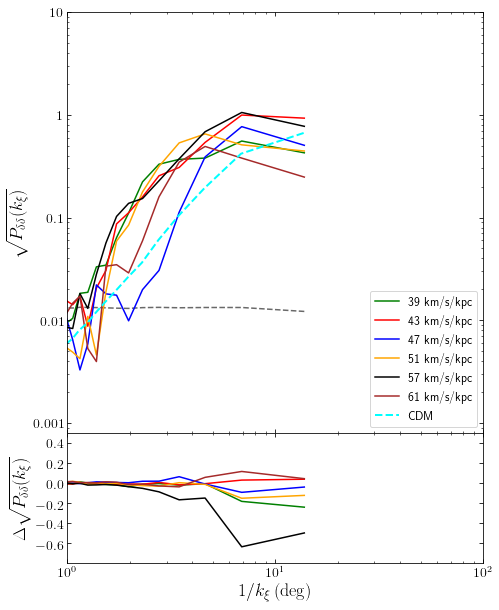

In [15]:
#plot analytic density and computed density 
from matplotlib.ticker import MultipleLocator

ml = MultipleLocator(5)
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,9)
axTop= pyplot.axes([0.15,0.3,0.825,0.65])
fig= pyplot.gcf()
fig.sca(axTop)

    
loglog(px0,py0,color='g',zorder=1,label=r'39 km/s/kpc')
loglog(px1,py1,color='r',zorder=1,label=r'43 km/s/kpc')
loglog(px0,pyerr1,color='dimgray',ls='--',zorder=1)
loglog(px2,py2,color='b',zorder=1,label=r'47 km/s/kpc')
loglog(px3,py3,color='orange',zorder=1,label=r'51 km/s/kpc')
loglog(px4,py4,color='k',zorder=1,label=r'57 km/s/kpc')
loglog(px5,py5,color='brown',zorder=1,label=r'61 km/s/kpc')
loglog(Px,Ppy,color='cyan',lw=2,ls='--',zorder=1,label=r'CDM')

#loglog(px,pyerr,lw=2.,color='k',zorder=1,ls='--')
legend(loc='lower right')

set_ranges_and_labels_dens_1()
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\xi})}$',fontsize=18)

#ylim(15.,10**11.)

nullfmt   = NullFormatter()         # no labels
axTop.xaxis.set_major_formatter(nullfmt)

axBottom= pyplot.axes([0.15,0.1,0.825,0.2])
fig= pyplot.gcf()
fig.sca(axBottom)


semilogx(sppx0,sppy0-spnppy0,color='g',zorder=1,label=r'39 km/s/kpc')
semilogx(sppx1,sppy1-spnppy1,color='r',zorder=1,label=r'43 km/s/kpc')
semilogx(sppx2,sppy2-spnppy2,color='b',zorder=1,label=r'47 km/s/kpc')
semilogx(sppx3,sppy3-spnppy3,color='orange',zorder=1,label=r'51 km/s/kpc')
semilogx(sppx4,sppy4-spnppy4,color='k',zorder=1,label=r'57 km/s/kpc')
semilogx(sppx5,sppy5-spnppy5,color='brown',zorder=1,label=r'61 km/s/kpc')
xlim(1,100.)
ylim(-0.8,0.5)
yticks([-0.6,-0.4,-0.2,0.,0.2,0.4])
plt.xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$',size=18)
plt.ylabel(r'$\Delta \sqrt{P_{\delta\delta}(k_{\xi})}$',size=18)
savefig('plots/power_vary_patspeed.pdf')

    


## Vary mass

In [58]:
#perturbed stream
method = 'spraydf'
pspeed=39.

M=[6*10**9.,8.*10**9.,10**10.,1.2*10**10.,1.4*10**10.]
Mstr=['6_10_9','8_10_9','1010','12_10_9','14_10_9']

for ii in range(2,len(M)) :
    print (Mstr[ii])
    dir1='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/{}Msun_39patspeed_{}/trailing/'.format(Mstr[ii],method)
    xi_t,eta_t,xi_l,eta_l=process_sample(900,dir1,out_format='xieta')
    xi_both_arms=include_both_arms(xi_t,eta_t,xi_l,eta_l)[:500000]
    print ('number %i'%len(xi_both_arms))
    
    midxi,Ndn,Ndn_err,nden,nden_err,pp = compute_ndenxi(xi_both_arms)
    
    outdir=dir1.replace('trailing','')
    fo=open(outdir + 'Pal5_density_botharms_{}Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(Mstr[ii],method),'w')
    fo.write("#xi    den_contrast    shot_noise" + '\n')
    for jj in range(len(nden)):
        fo.write(str(midxi[jj]) + "   " + str(nden[jj]) + "   " + str(nden_err[jj]) + "\n")

    fo.close()

1010
500500 496001
number 500000
500000
no of xi bins = 141
433078
12_10_9
450000 446088
number 500000
500000
no of xi bins = 141
377922
14_10_9
450000 445978
number 500000
500000
no of xi bins = 141
359143


/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide



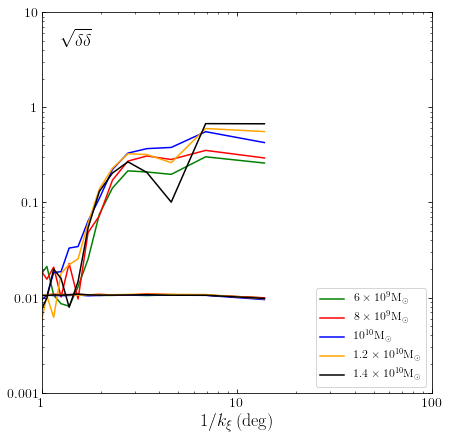

In [16]:
method = 'streamdf'

dir2='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/'
fname0=dir2 + '6_10_9Msun_39patspeed_{}/Pal5_density_botharms_6_10_9Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(method,method)
fname1=dir2 + '8_10_9Msun_39patspeed_{}/Pal5_density_botharms_8_10_9Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(method,method)
fname2=dir2 + '1010Msun_39patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(method,method)
fname3=dir2 + '12_10_9Msun_39patspeed_{}/Pal5_density_botharms_12_10_9Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(method,method)
fname4=dir2 + '14_10_9Msun_39patspeed_{}/Pal5_density_botharms_14_10_9Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(method,method)


px0,py0,pyerr0=compute_Pk(fname0, scaling = 'spectrum')
px1,py1,pyerr1=compute_Pk(fname1, scaling = 'spectrum')
px2,py2,pyerr2=compute_Pk(fname2, scaling = 'spectrum')
px3,py3,pyerr3=compute_Pk(fname3, scaling = 'spectrum')
px4,py4,pyerr4=compute_Pk(fname4, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)


loglog(px0,py0,color='g',zorder=1,label=r'$6\times 10^{9} \rm{M}_{\odot}$')
loglog(px0,pyerr0,color='g',zorder=1)
loglog(px1,py1,color='r',zorder=1,label=r'$8\times 10^{9} \rm{M}_{\odot}$')
loglog(px0,pyerr1,color='r',zorder=1)
loglog(px2,py2,color='b',zorder=1,label=r'$10^{10} \rm{M}_{\odot}$')
loglog(px0,pyerr2,color='b',zorder=1)
loglog(px3,py3,color='orange',zorder=1,label=r'$1.2\times 10^{10} \rm{M}_{\odot}$')
loglog(px0,pyerr3,color='orange',zorder=1)
loglog(px4,py4,color='k',zorder=1,label=r'$1.4\times 10^{10} \rm{M}_{\odot}$')
loglog(px0,pyerr4,color='k',zorder=1)

#loglog(px,pyerr,lw=2.,color='k',zorder=1,ls='--')
legend(loc='lower right')

set_ranges_and_labels_dens()
#savefig('plots/power_spraydf_noprog_5Gyrbarpot.pdf')

In [17]:
method = 'spraydf'

spdir2='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/'
spfname0=dir2 + '6_10_9Msun_39patspeed_{}/Pal5_density_botharms_6_10_9Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(method,method)
spfname1=dir2 + '8_10_9Msun_39patspeed_{}/Pal5_density_botharms_8_10_9Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(method,method)
spfname2=dir2 + '1010Msun_39patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(method,method)
spfname3=dir2 + '12_10_9Msun_39patspeed_{}/Pal5_density_botharms_12_10_9Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(method,method)
spfname4=dir2 + '14_10_9Msun_39patspeed_{}/Pal5_density_botharms_14_10_9Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(method,method)


sppx0,sppy0,sppyerr=compute_Pk(spfname0, scaling = 'spectrum')
sppx1,sppy1,sppyerr=compute_Pk(spfname1, scaling = 'spectrum')
sppx2,sppy2,sppyerr=compute_Pk(spfname2, scaling = 'spectrum')
sppx3,sppy3,sppyerr=compute_Pk(spfname3, scaling = 'spectrum')
sppx4,sppy4,sppyerr=compute_Pk(spfname4, scaling = 'spectrum')


method = 'spraydf_noprog'

spnpdir2='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/'
spnpfname0=dir2 + '6_10_9Msun_39patspeed_{}/Pal5_density_botharms_6_10_9Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(method,method)
spnpfname1=dir2 + '8_10_9Msun_39patspeed_{}/Pal5_density_botharms_8_10_9Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(method,method)
spnpfname2=dir2 + '1010Msun_39patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(method,method)
spnpfname3=dir2 + '12_10_9Msun_39patspeed_{}/Pal5_density_botharms_12_10_9Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(method,method)
spnpfname4=dir2 + '14_10_9Msun_39patspeed_{}/Pal5_density_botharms_14_10_9Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(method,method)

spnppx0,spnppy0,spnppyerr=compute_Pk(spnpfname0, scaling = 'spectrum')
spnppx1,spnppy1,spnppyerr=compute_Pk(spnpfname1, scaling = 'spectrum')
spnppx2,spnppy2,spnppyerr=compute_Pk(spnpfname2, scaling = 'spectrum')
spnppx3,spnppy3,spnppyerr=compute_Pk(spnpfname3, scaling = 'spectrum')
spnppx4,spnppy4,spnppyerr=compute_Pk(spnpfname4, scaling = 'spectrum')


/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide



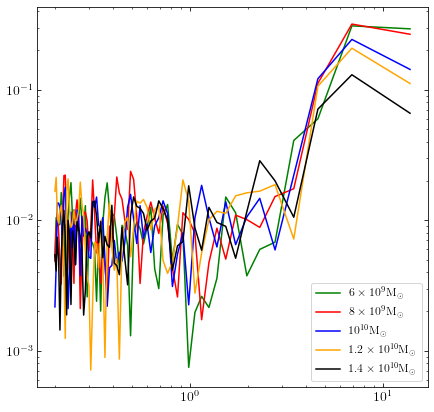

In [18]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

loglog(sppx0,sppy0,color='g',zorder=1,label=r'$6\times 10^{9} \rm{M}_{\odot}$')
loglog(sppx1,sppy1,color='r',zorder=1,label=r'$8\times 10^{9} \rm{M}_{\odot}$')
loglog(sppx2,sppy2,color='b',zorder=1,label=r'$ 10^{10} \rm{M}_{\odot}$')
loglog(sppx3,sppy3,color='orange',zorder=1,label=r'$1.2\times 10^{10} \rm{M}_{\odot}$')
loglog(sppx4,sppy4,color='k',zorder=1,label=r'$1.4\times 10^{10} \rm{M}_{\odot}$')
legend(loc='lower right')

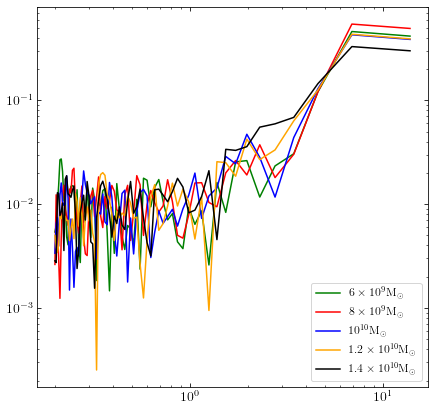

In [19]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

loglog(sppx0,spnppy0,color='g',zorder=1,label=r'$6\times 10^{9} \rm{M}_{\odot}$')
loglog(sppx1,spnppy1,color='r',zorder=1,label=r'$8\times 10^{9} \rm{M}_{\odot}$')
loglog(sppx2,spnppy2,color='b',zorder=1,label=r'$10^{10} \rm{M}_{\odot}$')
loglog(sppx3,spnppy3,color='orange',zorder=1,label=r'$1.2\times 10^{10} \rm{M}_{\odot}$')
loglog(sppx4,spnppy4,color='k',zorder=1,label=r'$1.4\times 10^{10} \rm{M}_{\odot}$')
legend(loc='lower right')

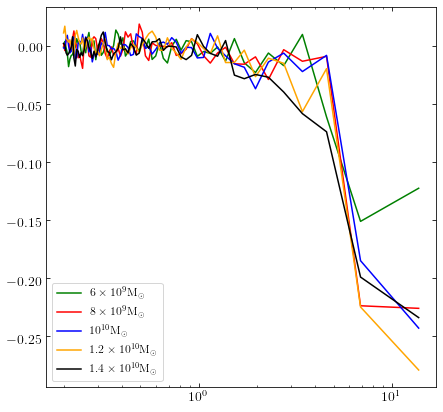

In [20]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

semilogx(sppx0,sppy0-spnppy0,color='g',zorder=1,label=r'$6\times 10^{9} \rm{M}_{\odot}$')
semilogx(sppx1,sppy1-spnppy1,color='r',zorder=1,label=r'$8\times 10^{9} \rm{M}_{\odot}$')
semilogx(sppx2,sppy2-spnppy2,color='b',zorder=1,label=r'$10^{10} \rm{M}_{\odot}$')
semilogx(sppx3,sppy3-spnppy3,color='orange',zorder=1,label=r'$1.2\times 10^{10} \rm{M}_{\odot}$')
semilogx(sppx4,sppy4-spnppy4,color='k',zorder=1,label=r'$1.4\times 10^{10} \rm{M}_{\odot}$')
legend(loc='lower left')


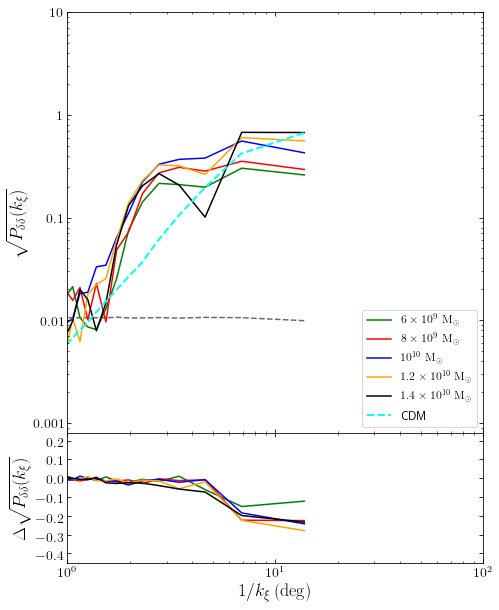

In [21]:
#plot analytic density and computed density 
from matplotlib.ticker import MultipleLocator

ml = MultipleLocator(5)
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,9)
axTop= pyplot.axes([0.15,0.3,0.825,0.65])
fig= pyplot.gcf()
fig.sca(axTop)

    
loglog(px0,py0,color='g',zorder=1,label=r'$6\times 10^{9} \ \rm{M}_{\odot}$')
loglog(px0,pyerr0,color='dimgray',ls='--',zorder=1)
loglog(px1,py1,color='r',zorder=1,label=r'$8\times 10^{9} \ \rm{M}_{\odot}$')
loglog(px2,py2,color='b',zorder=1,label=r'$10^{10} \ \rm{M}_{\odot}$')
loglog(px3,py3,color='orange',zorder=1,label=r'$1.2\times 10^{10} \ \rm{M}_{\odot}$')
loglog(px4,py4,color='k',zorder=1,label=r'$1.4\times 10^{10} \ \rm{M}_{\odot}$')
loglog(Px,Ppy,color='cyan',lw=2,ls='--',zorder=1,label=r'CDM')

#loglog(px,pyerr,lw=2.,color='k',zorder=1,ls='--')
legend(loc='lower right')

set_ranges_and_labels_dens_1()
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\xi})}$',fontsize=18)

#ylim(15.,10**11.)

nullfmt   = NullFormatter()         # no labels
axTop.xaxis.set_major_formatter(nullfmt)

axBottom= pyplot.axes([0.15,0.1,0.825,0.2])
fig= pyplot.gcf()
fig.sca(axBottom)


semilogx(sppx0,sppy0-spnppy0,color='g',zorder=1)
semilogx(sppx1,sppy1-spnppy1,color='r',zorder=1)
semilogx(sppx2,sppy2-spnppy2,color='b',zorder=1)
semilogx(sppx3,sppy3-spnppy3,color='orange',zorder=1)
semilogx(sppx4,sppy4-spnppy4,color='k',zorder=1)

xlim(1,100.)
ylim(-0.45,0.24)
yticks([-0.4,-0.3,-0.2,-0.1,0.,0.1,0.2])
plt.xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$',size=18)
plt.ylabel(r'$\Delta \sqrt{P_{\delta\delta}(k_{\xi})}$',size=18)
savefig('plots/power_vary_mass.pdf')

    


## Vary age of bar

In [19]:
#perturbed stream
method = 'streamdf'
age=[-1.,-2.,-3.,-4.,-5.]

age_str=['1Gyr','2Gyr','3Gyr','4Gyr']

for a in age_str :
    print (a)
    dir1='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/500k_samples/1010Msun_39patspeed_{}_{}/trailing/'.format(a,method)
    xi_t,eta_t,xi_l,eta_l=process_sample(dir1,out_format='xieta')
    xi_both_arms=include_both_arms(xi_t,eta_t,xi_l,eta_l)
    midxi,Ndn,Ndn_err,nden,nden_err,pp = compute_ndenxi(xi_both_arms)
    
    outdir=dir1.replace('trailing','')
    fo=open(outdir + 'Pal5_density_botharms_1010Msun_{}_{}_39patspeed_poly3norm.dat'.format(method,a),'w')
    fo.write("#xi    den_contrast    shot_noise" + '\n')
    for jj in range(len(nden)):
        fo.write(str(midxi[jj]) + "   " + str(nden[jj]) + "   " + str(nden_err[jj]) + "\n")

    fo.close()
    


1Gyr
500000 98011
598011
no of xi bins = 141
307624
2Gyr
500000 122332
622332
no of xi bins = 141
246280
3Gyr
500000 26439
526439
no of xi bins = 141
257959
4Gyr
500000 123282
623282
no of xi bins = 141
277954


/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide



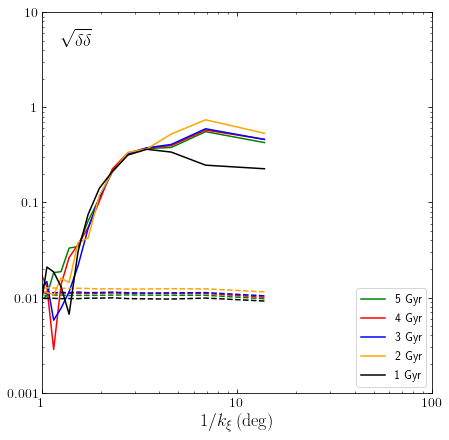

In [22]:
method = 'streamdf'

dir2='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/'
fname0=dir2 + '1010Msun_39patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(method,method)
fname1=dir2 + '1010Msun_39patspeed_4Gyr_{}/Pal5_density_botharms_1010Msun_{}_4Gyr_39patspeed_poly3norm.dat'.format(method,method)
fname2=dir2 + '1010Msun_39patspeed_3Gyr_{}/Pal5_density_botharms_1010Msun_{}_3Gyr_39patspeed_poly3norm.dat'.format(method,method)
fname3=dir2 + '1010Msun_39patspeed_2Gyr_{}/Pal5_density_botharms_1010Msun_{}_2Gyr_39patspeed_poly3norm.dat'.format(method,method)
fname4=dir2 + '1010Msun_39patspeed_1Gyr_{}/Pal5_density_botharms_1010Msun_{}_1Gyr_39patspeed_poly3norm.dat'.format(method,method)


px0,py0,pyerr0=compute_Pk(fname0, scaling = 'spectrum')
px1,py1,pyerr1=compute_Pk(fname1, scaling = 'spectrum')
px2,py2,pyerr2=compute_Pk(fname2, scaling = 'spectrum')
px3,py3,pyerr3=compute_Pk(fname3, scaling = 'spectrum')
px4,py4,pyerr4=compute_Pk(fname4, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)


loglog(px0,py0,color='g',zorder=1,label=r'5 Gyr')
loglog(px0,pyerr0,color='g',zorder=1,ls='--')
loglog(px1,py1,color='r',zorder=1,label=r'4 Gyr')
loglog(px0,pyerr1,color='r',zorder=1,ls='--')
loglog(px2,py2,color='b',zorder=1,label=r'3 Gyr')
loglog(px0,pyerr2,color='b',zorder=1,ls='--')
loglog(px3,py3,color='orange',zorder=1,label=r'2 Gyr')
loglog(px0,pyerr3,color='orange',zorder=1,ls='--')
loglog(px4,py4,color='k',zorder=1,label=r'1 Gyr')
loglog(px0,pyerr4,color='k',zorder=1,ls='--')

#loglog(px,pyerr,lw=2.,color='k',zorder=1,ls='--')
legend(loc='lower right')

set_ranges_and_labels_dens()
#savefig('plots/power_spraydf_noprog_5Gyrbarpot.pdf')

In [23]:
method = 'spraydf'

dir2='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/'
spfname0=dir2 + '1010Msun_39patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(method,method)
spfname1=dir2 + '1010Msun_39patspeed_4Gyr_{}/Pal5_density_botharms_1010Msun_{}_4Gyr_39patspeed_poly3norm.dat'.format(method,method)
spfname2=dir2 + '1010Msun_39patspeed_3Gyr_{}/Pal5_density_botharms_1010Msun_{}_3Gyr_39patspeed_poly3norm.dat'.format(method,method)
spfname3=dir2 + '1010Msun_39patspeed_2Gyr_{}/Pal5_density_botharms_1010Msun_{}_2Gyr_39patspeed_poly3norm.dat'.format(method,method)
spfname4=dir2 + '1010Msun_39patspeed_1Gyr_{}/Pal5_density_botharms_1010Msun_{}_1Gyr_39patspeed_poly3norm.dat'.format(method,method)


sppx0,sppy0,sppyerr=compute_Pk(spfname0, scaling = 'spectrum')
sppx1,sppy1,sppyerr=compute_Pk(spfname1, scaling = 'spectrum')
sppx2,sppy2,sppyerr=compute_Pk(spfname2, scaling = 'spectrum')
sppx3,sppy3,sppyerr=compute_Pk(spfname3, scaling = 'spectrum')
sppx4,sppy4,sppyerr=compute_Pk(spfname4, scaling = 'spectrum')


method = 'spraydf_noprog'

dir2='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/'
spnpfname0=dir2 + '1010Msun_39patspeed_{}/Pal5_density_botharms_1010Msun_{}_5Gyr_39patspeed_poly3norm.dat'.format(method,method)
spnpfname1=dir2 + '1010Msun_39patspeed_4Gyr_{}/Pal5_density_botharms_1010Msun_{}_4Gyr_39patspeed_poly3norm.dat'.format(method,method)
spnpfname2=dir2 + '1010Msun_39patspeed_3Gyr_{}/Pal5_density_botharms_1010Msun_{}_3Gyr_39patspeed_poly3norm.dat'.format(method,method)
spnpfname3=dir2 + '1010Msun_39patspeed_2Gyr_{}/Pal5_density_botharms_1010Msun_{}_2Gyr_39patspeed_poly3norm.dat'.format(method,method)
spnpfname4=dir2 + '1010Msun_39patspeed_1Gyr_{}/Pal5_density_botharms_1010Msun_{}_1Gyr_39patspeed_poly3norm.dat'.format(method,method)

spnppx0,spnppy0,spnppyerr=compute_Pk(spnpfname0, scaling = 'spectrum')
spnppx1,spnppy1,spnppyerr=compute_Pk(spnpfname1, scaling = 'spectrum')
spnppx2,spnppy2,spnppyerr=compute_Pk(spnpfname2, scaling = 'spectrum')
spnppx3,spnppy3,spnppyerr=compute_Pk(spnpfname3, scaling = 'spectrum')
spnppx4,spnppy4,spnppyerr=compute_Pk(spnpfname4, scaling = 'spectrum')


/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide



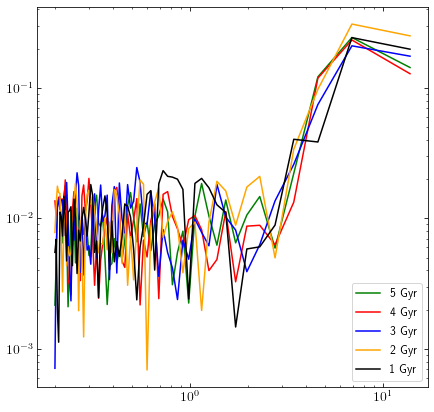

In [24]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

loglog(sppx0,sppy0,color='g',zorder=1,label=r'5 Gyr')
loglog(sppx1,sppy1,color='r',zorder=1,label=r'4 Gyr')
loglog(sppx2,sppy2,color='b',zorder=1,label=r'3 Gyr')
loglog(sppx3,sppy3,color='orange',zorder=1,label=r'2 Gyr')
loglog(sppx4,sppy4,color='k',zorder=1,label=r'1 Gyr')
legend(loc='lower right')

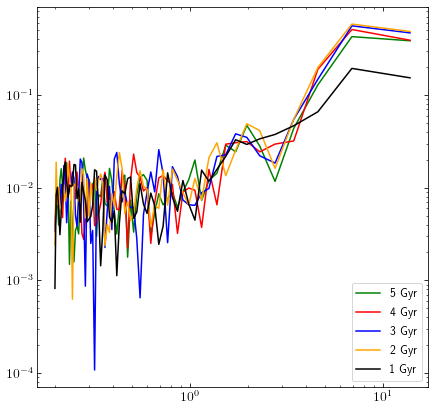

In [25]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

loglog(sppx0,spnppy0,color='g',zorder=1,label=r'5 Gyr')
loglog(sppx1,spnppy1,color='r',zorder=1,label=r'4 Gyr')
loglog(sppx2,spnppy2,color='b',zorder=1,label=r'3 Gyr')
loglog(sppx3,spnppy3,color='orange',zorder=1,label=r'2 Gyr')
loglog(sppx4,spnppy4,color='k',zorder=1,label=r'1 Gyr')
legend(loc='lower right')

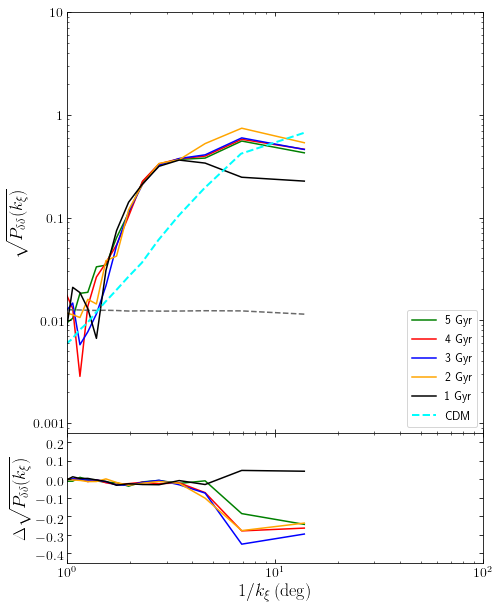

In [26]:
#plot analytic density and computed density 
from matplotlib.ticker import MultipleLocator

ml = MultipleLocator(5)
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,9)
axTop= pyplot.axes([0.15,0.3,0.825,0.65])
fig= pyplot.gcf()
fig.sca(axTop)

    
loglog(px0,py0,color='g',zorder=1,label=r'5 Gyr')
loglog(px1,py1,color='r',zorder=1,label=r'4 Gyr')
loglog(px2,py2,color='b',zorder=1,label=r'3 Gyr')
loglog(px3,py3,color='orange',zorder=1,label=r'2 Gyr')
loglog(px3,pyerr3,color='dimgray',ls='--',zorder=1)
loglog(px4,py4,color='k',zorder=1,label=r'1 Gyr')
loglog(Px,Ppy,color='cyan',lw=2,ls='--',zorder=1,label=r'CDM')

#loglog(px,pyerr,lw=2.,color='k',zorder=1,ls='--')
legend(loc='lower right')

set_ranges_and_labels_dens_1()
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\xi})}$',fontsize=18)

#ylim(15.,10**11.)

nullfmt   = NullFormatter()         # no labels
axTop.xaxis.set_major_formatter(nullfmt)

axBottom= pyplot.axes([0.15,0.1,0.825,0.2])
fig= pyplot.gcf()
fig.sca(axBottom)


semilogx(sppx0,sppy0-spnppy0,color='g',zorder=1)
semilogx(sppx1,sppy1-spnppy1,color='r',zorder=1)
semilogx(sppx2,sppy2-spnppy2,color='b',zorder=1)
semilogx(sppx3,sppy3-spnppy3,color='orange',zorder=1)
semilogx(sppx4,sppy4-spnppy4,color='k',zorder=1)

xlim(1,100.)
ylim(-0.45,0.25)
yticks([-0.4,-0.3,-0.2,-0.1,0.,0.1,0.2])
plt.xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$',size=18)
plt.ylabel(r'$\Delta \sqrt{P_{\delta\delta}(k_{\xi})}$',size=18)
savefig('plots/power_vary_age.pdf')

    


## Spirals

In [10]:
#perturbed stream

method = 'spraydf_noprog'

N=[2,4]
pspeed=[19.5,24.5]
age=[1,3,5]
FR=[0.5,1.0]


for t in age:
    
    for fr in FR :
        
        for n in N :
            
            for p in pspeed :
                
                print (t,fr,n,p)
                dir1='/home/nil/Dropbox/streamgap-pepper/sampled_spiral/spiralN{}_{}patspeed_FR{}_{}Gyr_{}/trailing/'.format(n,p,fr,t,method)
                xi_t,eta_t,xi_l,eta_l=process_sample(dir1,out_format='xieta')
                xi_both_arms=include_both_arms(xi_t,eta_t,xi_l,eta_l)
                
                midxi,Ndn,Ndn_err,nden,nden_err,pp = compute_ndenxi(xi_both_arms)
    
                outdir=dir1.replace('trailing','')
                fo=open(outdir + 'Pal5_density_botharms_spiralN{}_{}patspeed_FR{}_{}Gyr_{}_poly3norm.dat'.format(n,p,fr,t,method),'w')
                fo.write("#xi    den_contrast    shot_noise" + '\n')
                for jj in range(len(nden)):
                    fo.write(str(midxi[jj]) + "   " + str(nden[jj]) + "   " + str(nden_err[jj]) + "\n")

                fo.close()
                
                
                
                
                

1 0.5 2 19.5
500000 494657
994657
no of xi bins = 141
403463
1 0.5 2 24.5
500000 495369
995369
no of xi bins = 141
405843
1 0.5 4 19.5
500000 495316
995316
no of xi bins = 141
401206
1 0.5 4 24.5
500000 495834
995834
no of xi bins = 141
400949
1 1.0 2 19.5
500000 495507
995507
no of xi bins = 141
404049
1 1.0 2 24.5
500000 495271
995271
no of xi bins = 141
407177
1 1.0 4 19.5
500000 495591
995591
no of xi bins = 141
398351
1 1.0 4 24.5
500000 495837
995837
no of xi bins = 141
397307
3 0.5 2 19.5
500000 495327
995327
no of xi bins = 141
404563
3 0.5 2 24.5
500000 495436
995436
no of xi bins = 141
406448
3 0.5 4 19.5
500000 495598
995598
no of xi bins = 141
405575
3 0.5 4 24.5
500000 495616
995616
no of xi bins = 141
390397
3 1.0 2 19.5
500000 494941
994941
no of xi bins = 141
406214
3 1.0 2 24.5
500000 495011
995011
no of xi bins = 141
409560
3 1.0 4 19.5
500000 495531
995531
no of xi bins = 141
407305
3 1.0 4 24.5
500000 495596
995596
no of xi bins = 141
379291
5 0.5 2 19.5
500000 4950

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide



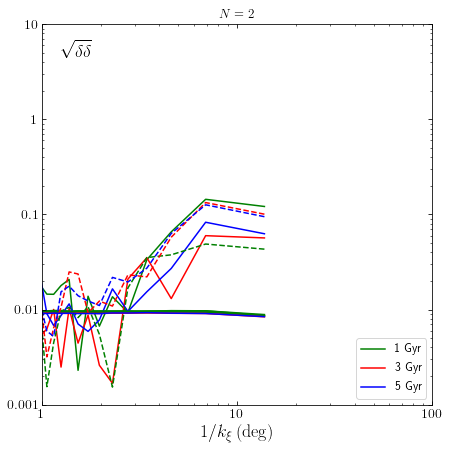

In [27]:
#vary age

method = 'streamdf'

dir2='/home/nil/Dropbox/streamgap-pepper/sampled_spiral/'
fname0=dir2 + 'spiralN2_24.5patspeed_FR1.0_1Gyr_{}/Pal5_density_botharms_spiralN2_24.5patspeed_FR1.0_1Gyr_{}_poly3norm.dat'.format(method,method)
fname1=dir2 + 'spiralN2_24.5patspeed_FR1.0_3Gyr_{}/Pal5_density_botharms_spiralN2_24.5patspeed_FR1.0_3Gyr_{}_poly3norm.dat'.format(method,method)
fname2=dir2 + 'spiralN2_24.5patspeed_FR1.0_5Gyr_{}/Pal5_density_botharms_spiralN2_24.5patspeed_FR1.0_5Gyr_{}_poly3norm.dat'.format(method,method)

fname3=dir2 + 'spiralN2_19.5patspeed_FR1.0_1Gyr_{}/Pal5_density_botharms_spiralN2_19.5patspeed_FR1.0_1Gyr_{}_poly3norm.dat'.format(method,method)
fname4=dir2 + 'spiralN2_19.5patspeed_FR1.0_3Gyr_{}/Pal5_density_botharms_spiralN2_19.5patspeed_FR1.0_3Gyr_{}_poly3norm.dat'.format(method,method)
fname5=dir2 + 'spiralN2_19.5patspeed_FR1.0_5Gyr_{}/Pal5_density_botharms_spiralN2_19.5patspeed_FR1.0_5Gyr_{}_poly3norm.dat'.format(method,method)


px0,py0,pyerr0=compute_Pk(fname0, scaling = 'spectrum')
px1,py1,pyerr1=compute_Pk(fname1, scaling = 'spectrum')
px2,py2,pyerr2=compute_Pk(fname2, scaling = 'spectrum')
px3,py3,pyerr3=compute_Pk(fname3, scaling = 'spectrum')
px4,py4,pyerr4=compute_Pk(fname4, scaling = 'spectrum')
px5,py5,pyerr5=compute_Pk(fname5, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

title(r'$N=2$')
loglog(px0,py0,color='g',zorder=1,label=r'1 Gyr')
loglog(px0,pyerr0,color='g',zorder=1)
loglog(px1,py1,color='r',zorder=1,label=r'3 Gyr')
loglog(px0,pyerr1,color='g',zorder=1)
loglog(px2,py2,color='b',zorder=1,label=r'5 Gyr')
loglog(px0,pyerr2,color='g',zorder=1)
loglog(px3,py3,color='g',ls='--',zorder=1)
loglog(px0,pyerr3,color='g',zorder=1)
loglog(px4,py4,color='r',ls='--',zorder=1)
loglog(px0,pyerr4,color='r',zorder=1)
loglog(px5,py5,color='b',ls='--',zorder=1)
loglog(px0,pyerr5,color='b',zorder=1)
#loglog(px,pyerr,lw=2.,color='k',zorder=1,ls='--')
legend(loc='lower right')
set_ranges_and_labels_dens()

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide



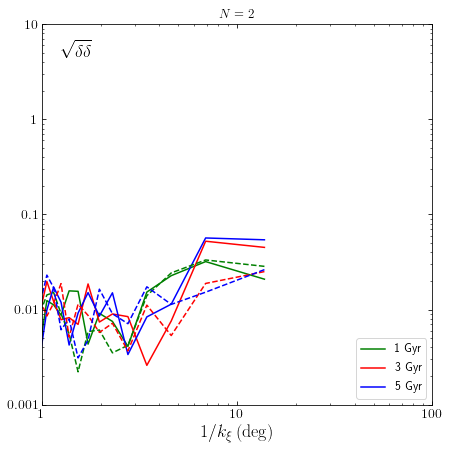

In [28]:
#vary age

method = 'spraydf'

dir2='/home/nil/Dropbox/streamgap-pepper/sampled_spiral/'
fname0=dir2 + 'spiralN2_24.5patspeed_FR1.0_1Gyr_{}/Pal5_density_botharms_spiralN2_24.5patspeed_FR1.0_1Gyr_{}_poly3norm.dat'.format(method,method)
fname1=dir2 + 'spiralN2_24.5patspeed_FR1.0_3Gyr_{}/Pal5_density_botharms_spiralN2_24.5patspeed_FR1.0_3Gyr_{}_poly3norm.dat'.format(method,method)
fname2=dir2 + 'spiralN2_24.5patspeed_FR1.0_5Gyr_{}/Pal5_density_botharms_spiralN2_24.5patspeed_FR1.0_5Gyr_{}_poly3norm.dat'.format(method,method)

fname3=dir2 + 'spiralN2_19.5patspeed_FR1.0_1Gyr_{}/Pal5_density_botharms_spiralN2_19.5patspeed_FR1.0_1Gyr_{}_poly3norm.dat'.format(method,method)
fname4=dir2 + 'spiralN2_19.5patspeed_FR1.0_3Gyr_{}/Pal5_density_botharms_spiralN2_19.5patspeed_FR1.0_3Gyr_{}_poly3norm.dat'.format(method,method)
fname5=dir2 + 'spiralN2_19.5patspeed_FR1.0_5Gyr_{}/Pal5_density_botharms_spiralN2_19.5patspeed_FR1.0_5Gyr_{}_poly3norm.dat'.format(method,method)


sppx0,sppy0,pyerr=compute_Pk(fname0, scaling = 'spectrum')
sppx1,sppy1,pyerr=compute_Pk(fname1, scaling = 'spectrum')
sppx2,sppy2,pyerr=compute_Pk(fname2, scaling = 'spectrum')
sppx3,sppy3,pyerr=compute_Pk(fname3, scaling = 'spectrum')
sppx4,sppy4,pyerr=compute_Pk(fname4, scaling = 'spectrum')
sppx5,sppy5,pyerr=compute_Pk(fname5, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

title(r'$N=2$')
loglog(sppx0,sppy0,color='g',zorder=1,label=r'1 Gyr')
loglog(sppx1,sppy1,color='r',zorder=1,label=r'3 Gyr')
loglog(sppx2,sppy2,color='b',zorder=1,label=r'5 Gyr')
loglog(sppx3,sppy3,color='g',ls='--',zorder=1)
loglog(sppx4,sppy4,color='r',ls='--',zorder=1)
loglog(sppx5,sppy5,color='b',ls='--',zorder=1)
#loglog(px,pyerr,lw=2.,color='k',zorder=1,ls='--')
legend(loc='lower right')
set_ranges_and_labels_dens()

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide



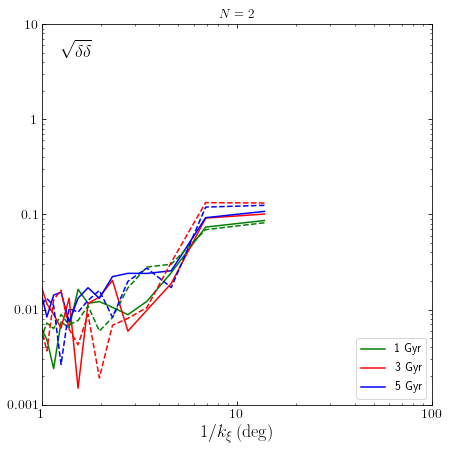

In [29]:
#vary age

method = 'spraydf_noprog'

dir2='/home/nil/Dropbox/streamgap-pepper/sampled_spiral/'
fname0=dir2 + 'spiralN2_24.5patspeed_FR1.0_1Gyr_{}/Pal5_density_botharms_spiralN2_24.5patspeed_FR1.0_1Gyr_{}_poly3norm.dat'.format(method,method)
fname1=dir2 + 'spiralN2_24.5patspeed_FR1.0_3Gyr_{}/Pal5_density_botharms_spiralN2_24.5patspeed_FR1.0_3Gyr_{}_poly3norm.dat'.format(method,method)
fname2=dir2 + 'spiralN2_24.5patspeed_FR1.0_5Gyr_{}/Pal5_density_botharms_spiralN2_24.5patspeed_FR1.0_5Gyr_{}_poly3norm.dat'.format(method,method)

fname3=dir2 + 'spiralN2_19.5patspeed_FR1.0_1Gyr_{}/Pal5_density_botharms_spiralN2_19.5patspeed_FR1.0_1Gyr_{}_poly3norm.dat'.format(method,method)
fname4=dir2 + 'spiralN2_19.5patspeed_FR1.0_3Gyr_{}/Pal5_density_botharms_spiralN2_19.5patspeed_FR1.0_3Gyr_{}_poly3norm.dat'.format(method,method)
fname5=dir2 + 'spiralN2_19.5patspeed_FR1.0_5Gyr_{}/Pal5_density_botharms_spiralN2_19.5patspeed_FR1.0_5Gyr_{}_poly3norm.dat'.format(method,method)


spnppx0,spnppy0,pyerr=compute_Pk(fname0, scaling = 'spectrum')
spnppx1,spnppy1,pyerr=compute_Pk(fname1, scaling = 'spectrum')
spnppx2,spnppy2,pyerr=compute_Pk(fname2, scaling = 'spectrum')
spnppx3,spnppy3,pyerr=compute_Pk(fname3, scaling = 'spectrum')
spnppx4,spnppy4,pyerr=compute_Pk(fname4, scaling = 'spectrum')
spnppx5,spnppy5,pyerr=compute_Pk(fname5, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

title(r'$N=2$')
loglog(spnppx0,spnppy0,color='g',zorder=1,label=r'1 Gyr')
loglog(spnppx1,spnppy1,color='r',zorder=1,label=r'3 Gyr')
loglog(spnppx2,spnppy2,color='b',zorder=1,label=r'5 Gyr')
loglog(spnppx3,spnppy3,color='g',ls='--',zorder=1)
loglog(spnppx4,spnppy4,color='r',ls='--',zorder=1)
loglog(spnppx5,spnppy5,color='b',ls='--',zorder=1)
#loglog(px,pyerr,lw=2.,color='k',zorder=1,ls='--')
legend(loc='lower right')
set_ranges_and_labels_dens()

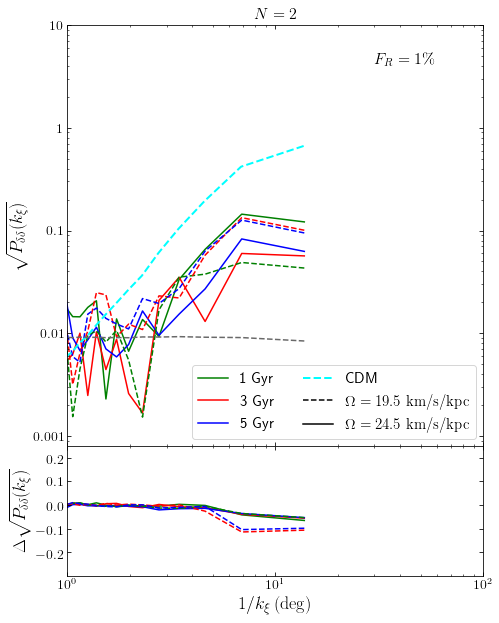

In [30]:
#plot analytic density and computed density 
from matplotlib.ticker import MultipleLocator

ml = MultipleLocator(5)
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,9)
axTop= pyplot.axes([0.15,0.3,0.825,0.65])
fig= pyplot.gcf()
fig.sca(axTop)

title(r'$N=2$',fontsize=16)   
loglog(px0,py0,color='g',zorder=1,label=r'1 Gyr')
loglog(px1,py1,color='r',zorder=1,label=r'3 Gyr')
loglog(px2,py2,color='b',zorder=1,label=r'5 Gyr')

loglog(px3,py3,color='g',zorder=1,ls='--')
loglog(px4,py4,color='r',zorder=1,ls='--')
loglog(px5,py5,color='b',zorder=1,ls='--')
loglog(Px,Ppy,color='cyan',lw=2,ls='--',zorder=1,label=r'CDM')
loglog(px0,pyerr5,color='dimgray',ls='--',zorder=1)

loglog([0,0],[200,200],ls='--',c='k',label=r'$\Omega = 19.5 \ \rm{km/s/kpc}$')
loglog([0,0],[200,200],c='k',label=r'$\Omega = 24.5 \ \rm{km/s/kpc}$')
text(30,4,r'$F_{R} = 1\%$',fontsize=16)

#loglog(px,pyerr,lw=2.,color='k',zorder=1,ls='--')
legend(loc='lower right',ncol=2,fontsize=15)

set_ranges_and_labels_dens_1()
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\xi})}$',fontsize=18)

#ylim(15.,10**11.)

nullfmt   = NullFormatter()         # no labels
axTop.xaxis.set_major_formatter(nullfmt)

axBottom= pyplot.axes([0.15,0.1,0.825,0.2])
fig= pyplot.gcf()
fig.sca(axBottom)


semilogx(sppx0,sppy0-spnppy0,color='g',zorder=1)
semilogx(sppx1,sppy1-spnppy1,color='r',zorder=1)
semilogx(sppx2,sppy2-spnppy2,color='b',zorder=1)
semilogx(sppx3,sppy3-spnppy3,color='g',ls='--',zorder=1)
semilogx(sppx4,sppy4-spnppy4,color='r',ls='--',zorder=1)
semilogx(sppx5,sppy5-spnppy5,color='b',ls='--',zorder=1)

xlim(1,100.)
ylim(-0.3,0.25)
yticks([-0.2,-0.1,0.,0.1,0.2])
plt.xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$',size=18)
plt.ylabel(r'$\Delta \sqrt{P_{\delta\delta}(k_{\xi})}$',size=18)
savefig('plots/power_spiral_N2_FR1.0_vary_age.pdf')

    


In [36]:
#vary age

method = 'streamdf'

dir2='/home/nil/Dropbox/streamgap-pepper/sampled_spiral/'
fname0=dir2 + 'spiralN4_24.5patspeed_FR1.0_1Gyr_{}/Pal5_density_botharms_spiralN4_24.5patspeed_FR1.0_1Gyr_{}_poly3norm.dat'.format(method,method)
fname1=dir2 + 'spiralN4_24.5patspeed_FR1.0_3Gyr_{}/Pal5_density_botharms_spiralN4_24.5patspeed_FR1.0_3Gyr_{}_poly3norm.dat'.format(method,method)
fname2=dir2 + 'spiralN4_24.5patspeed_FR1.0_5Gyr_{}/Pal5_density_botharms_spiralN4_24.5patspeed_FR1.0_5Gyr_{}_poly3norm.dat'.format(method,method)

fname3=dir2 + 'spiralN4_19.5patspeed_FR1.0_1Gyr_{}/Pal5_density_botharms_spiralN4_19.5patspeed_FR1.0_1Gyr_{}_poly3norm.dat'.format(method,method)
fname4=dir2 + 'spiralN4_19.5patspeed_FR1.0_3Gyr_{}/Pal5_density_botharms_spiralN4_19.5patspeed_FR1.0_3Gyr_{}_poly3norm.dat'.format(method,method)
fname5=dir2 + 'spiralN4_19.5patspeed_FR1.0_5Gyr_{}/Pal5_density_botharms_spiralN4_19.5patspeed_FR1.0_5Gyr_{}_poly3norm.dat'.format(method,method)


px0,py0,pyerr0=compute_Pk(fname0, scaling = 'spectrum')
px1,py1,pyerr1=compute_Pk(fname1, scaling = 'spectrum')
px2,py2,pyerr2=compute_Pk(fname2, scaling = 'spectrum')
px3,py3,pyerr3=compute_Pk(fname3, scaling = 'spectrum')
px4,py4,pyerr4=compute_Pk(fname4, scaling = 'spectrum')
px5,py5,pyerr5=compute_Pk(fname5, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

title(r'$N=4$')
loglog(px0,py0,color='g',zorder=1,label=r'1 Gyr')
loglog(px0,pyerr0,color='g',zorder=1)
loglog(px1,py1,color='r',zorder=1,label=r'3 Gyr')
loglog(px0,pyerr1,color='r',zorder=1)
loglog(px2,py2,color='b',zorder=1,label=r'5 Gyr')
loglog(px0,pyerr2,color='g',zorder=1)
loglog(px3,py3,color='g',ls='--',zorder=1)
loglog(px0,pyerr3,color='g',zorder=1)
loglog(px4,py4,color='r',ls='--',zorder=1)
loglog(px0,pyerr4,color='r',zorder=1)
loglog(px5,py5,color='b',ls='--',zorder=1)
loglog(px0,pyerr5,color='b',zorder=1)
#loglog(px,pyerr,lw=2.,color='k',zorder=1,ls='--')
legend(loc='lower right')
set_ranges_and_labels_dens()

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide



OSError: /home/nil/Dropbox/streamgap-pepper/sampled_spiral/spiralN4_19.5patspeed_FR1.0_3Gyr_streamdf/Pal5_density_botharms_spiralN4_19.5patspeed_FR1.0_3Gyr_streamdf_poly3norm.dat not found.

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide



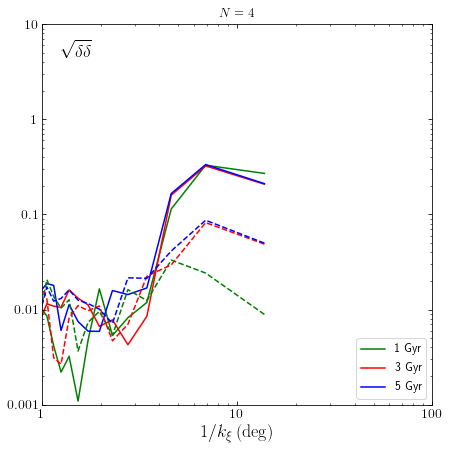

In [32]:
#vary age

method = 'spraydf'

dir2='/home/nil/Dropbox/streamgap-pepper/sampled_spiral/'
fname0=dir2 + 'spiralN4_24.5patspeed_FR1.0_1Gyr_{}/Pal5_density_botharms_spiralN4_24.5patspeed_FR1.0_1Gyr_{}_poly3norm.dat'.format(method,method)
fname1=dir2 + 'spiralN4_24.5patspeed_FR1.0_3Gyr_{}/Pal5_density_botharms_spiralN4_24.5patspeed_FR1.0_3Gyr_{}_poly3norm.dat'.format(method,method)
fname2=dir2 + 'spiralN4_24.5patspeed_FR1.0_5Gyr_{}/Pal5_density_botharms_spiralN4_24.5patspeed_FR1.0_5Gyr_{}_poly3norm.dat'.format(method,method)

fname3=dir2 + 'spiralN4_19.5patspeed_FR1.0_1Gyr_{}/Pal5_density_botharms_spiralN4_19.5patspeed_FR1.0_1Gyr_{}_poly3norm.dat'.format(method,method)
fname4=dir2 + 'spiralN4_19.5patspeed_FR1.0_3Gyr_{}/Pal5_density_botharms_spiralN4_19.5patspeed_FR1.0_3Gyr_{}_poly3norm.dat'.format(method,method)
fname5=dir2 + 'spiralN4_19.5patspeed_FR1.0_5Gyr_{}/Pal5_density_botharms_spiralN4_19.5patspeed_FR1.0_5Gyr_{}_poly3norm.dat'.format(method,method)


sppx0,sppy0,pyerr=compute_Pk(fname0, scaling = 'spectrum')
sppx1,sppy1,pyerr=compute_Pk(fname1, scaling = 'spectrum')
sppx2,sppy2,pyerr=compute_Pk(fname2, scaling = 'spectrum')
sppx3,sppy3,pyerr=compute_Pk(fname3, scaling = 'spectrum')
sppx4,sppy4,pyerr=compute_Pk(fname4, scaling = 'spectrum')
sppx5,sppy5,pyerr=compute_Pk(fname5, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

title(r'$N=4$')
loglog(sppx0,sppy0,color='g',zorder=1,label=r'1 Gyr')
loglog(sppx1,sppy1,color='r',zorder=1,label=r'3 Gyr')
loglog(sppx2,sppy2,color='b',zorder=1,label=r'5 Gyr')
loglog(sppx3,sppy3,color='g',ls='--',zorder=1)
loglog(sppx4,sppy4,color='r',ls='--',zorder=1)
loglog(sppx5,sppy5,color='b',ls='--',zorder=1)
#loglog(px,pyerr,lw=2.,color='k',zorder=1,ls='--')
legend(loc='lower right')
set_ranges_and_labels_dens()

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide



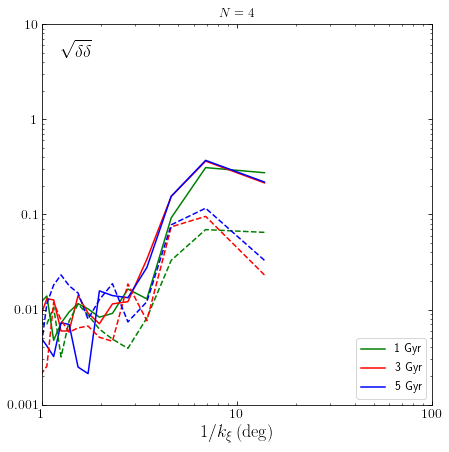

In [33]:
#vary age

method = 'spraydf_noprog'

dir2='/home/nil/Dropbox/streamgap-pepper/sampled_spiral/'
fname0=dir2 + 'spiralN4_24.5patspeed_FR1.0_1Gyr_{}/Pal5_density_botharms_spiralN4_24.5patspeed_FR1.0_1Gyr_{}_poly3norm.dat'.format(method,method)
fname1=dir2 + 'spiralN4_24.5patspeed_FR1.0_3Gyr_{}/Pal5_density_botharms_spiralN4_24.5patspeed_FR1.0_3Gyr_{}_poly3norm.dat'.format(method,method)
fname2=dir2 + 'spiralN4_24.5patspeed_FR1.0_5Gyr_{}/Pal5_density_botharms_spiralN4_24.5patspeed_FR1.0_5Gyr_{}_poly3norm.dat'.format(method,method)

fname3=dir2 + 'spiralN4_19.5patspeed_FR1.0_1Gyr_{}/Pal5_density_botharms_spiralN4_19.5patspeed_FR1.0_1Gyr_{}_poly3norm.dat'.format(method,method)
fname4=dir2 + 'spiralN4_19.5patspeed_FR1.0_3Gyr_{}/Pal5_density_botharms_spiralN4_19.5patspeed_FR1.0_3Gyr_{}_poly3norm.dat'.format(method,method)
fname5=dir2 + 'spiralN4_19.5patspeed_FR1.0_5Gyr_{}/Pal5_density_botharms_spiralN4_19.5patspeed_FR1.0_5Gyr_{}_poly3norm.dat'.format(method,method)


spnppx0,spnppy0,pyerr=compute_Pk(fname0, scaling = 'spectrum')
spnppx1,spnppy1,pyerr=compute_Pk(fname1, scaling = 'spectrum')
spnppx2,spnppy2,pyerr=compute_Pk(fname2, scaling = 'spectrum')
spnppx3,spnppy3,pyerr=compute_Pk(fname3, scaling = 'spectrum')
spnppx4,spnppy4,pyerr=compute_Pk(fname4, scaling = 'spectrum')
spnppx5,spnppy5,pyerr=compute_Pk(fname5, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

title(r'$N=4$')
loglog(spnppx0,spnppy0,color='g',zorder=1,label=r'1 Gyr')
loglog(spnppx1,spnppy1,color='r',zorder=1,label=r'3 Gyr')
loglog(spnppx2,spnppy2,color='b',zorder=1,label=r'5 Gyr')
loglog(spnppx3,spnppy3,color='g',ls='--',zorder=1)
loglog(spnppx4,spnppy4,color='r',ls='--',zorder=1)
loglog(spnppx5,spnppy5,color='b',ls='--',zorder=1)
#loglog(px,pyerr,lw=2.,color='k',zorder=1,ls='--')
legend(loc='lower right')
set_ranges_and_labels_dens()

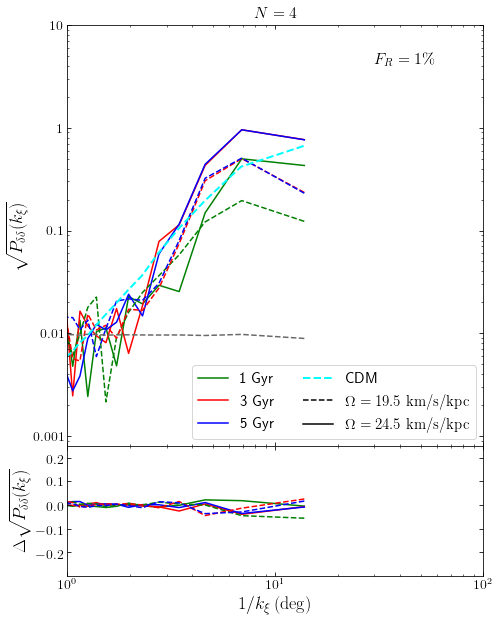

In [34]:
#plot analytic density and computed density 
from matplotlib.ticker import MultipleLocator

ml = MultipleLocator(5)
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,9)
axTop= pyplot.axes([0.15,0.3,0.825,0.65])
fig= pyplot.gcf()
fig.sca(axTop)

title(r'$N=4$',fontsize=16)   
loglog(px0,py0,color='g',zorder=1,label=r'1 Gyr')
loglog(px1,py1,color='r',zorder=1,label=r'3 Gyr')
loglog(px2,py2,color='b',zorder=1,label=r'5 Gyr')

loglog(px3,py3,color='g',zorder=1,ls='--')
loglog(px4,py4,color='r',zorder=1,ls='--')
loglog(px5,py5,color='b',zorder=1,ls='--')
loglog(px0,pyerr0,color='dimgray',ls='--',zorder=1)
loglog(Px,Ppy,color='cyan',lw=2,ls='--',zorder=1,label=r'CDM')
loglog([0,0],[200,200],ls='--',c='k',label=r'$\Omega = 19.5 \ \rm{km/s/kpc}$')
loglog([0,0],[200,200],c='k',label=r'$\Omega = 24.5 \ \rm{km/s/kpc}$')

text(30,4,r'$F_{R} = 1\%$',fontsize=16)

#loglog(px,pyerr,lw=2.,color='k',zorder=1,ls='--')
legend(loc='lower right',ncol=2,fontsize=15)

set_ranges_and_labels_dens_1()
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\xi})}$',fontsize=18)

#ylim(15.,10**11.)

nullfmt   = NullFormatter()         # no labels
axTop.xaxis.set_major_formatter(nullfmt)

axBottom= pyplot.axes([0.15,0.1,0.825,0.2])
fig= pyplot.gcf()
fig.sca(axBottom)


semilogx(sppx0,sppy0-spnppy0,color='g',zorder=1)
semilogx(sppx1,sppy1-spnppy1,color='r',zorder=1)
semilogx(sppx2,sppy2-spnppy2,color='b',zorder=1)
semilogx(sppx3,sppy3-spnppy3,color='g',ls='--',zorder=1)
semilogx(sppx4,sppy4-spnppy4,color='r',ls='--',zorder=1)
semilogx(sppx5,sppy5-spnppy5,color='b',ls='--',zorder=1)

xlim(1,100.)
ylim(-0.3,0.25)
yticks([-0.2,-0.1,0.,0.1,0.2])
plt.xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$',size=18)
plt.ylabel(r'$\Delta \sqrt{P_{\delta\delta}(k_{\xi})}$',size=18)
savefig('plots/power_spiral_N4_FR1.0_vary_age.pdf')

    


In [43]:
def convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3,poly_norm=True):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    #print (mradec)
    mxieta= pal5_util_old.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    pp= Polynomial.fit(apars,dens,deg=3)
    outll= numpy.arange(0.65,14.35,0.1)
    # Interpolate density
    ipll= interpolate.InterpolatedUnivariateSpline(mxieta[:,0],apars)
    
    if poly_norm:
        ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/pp(apars))
        
    else :
        ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    
    return (outll,ipdens(ipll(outll)))


def set_ranges_and_labels_dens():
    #bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    ylabel(r'$\sqrt{P_{\delta\delta}(k_{\xi})}$',fontsize=18)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$',size=18)
    ylim(0.0008,10.)
    xlim(1,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None


def pk_scatter(fname,N,scatter=False,zorder=1,ls='-',lw=2.):
    
    filename0=fname + '0.dat'
    dat0=np.loadtxt(filename0)
    ll=dat0[:,0][4:]
    tdata=dat0[:,1][4:]
    px,py= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))
    py= py.real
       
    ppy= numpy.empty((N,len(px)))
    
    ppy[0]=py
    
    for ii in range(1,N):
        filename=fname + '{}.dat'.format(ii)
        dat=np.loadtxt(filename)
        ll=dat[:,0][4:]
        tdata=dat[:,1][4:]
        ppy[ii]= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))[1].real
           
    if not scatter:
            
        return (1./px,numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0])))
        
    else:
        out= numpy.sqrt(numpy.nanmedian(ppy,axis=0)*numpy.abs(ll[-1]-ll[0]))
                
        ppy.sort(axis=0)
        
        return (1./px,out,
                numpy.sqrt(ppy[int(numpy.round(0.023*N))]*(ll[-1]-ll[0])),
                numpy.sqrt(ppy[int(numpy.round(0.977*N)-1)]*(ll[-1]-ll[0])))
                #numpy.sqrt(ppy[int(numpy.round(0.159*N))]*(ll[-1]-ll[0])),
                #numpy.sqrt(ppy[int(numpy.round(0.84*N)-2)]*(ll[-1]-ll[0])))
                
    
def plot_pk_scatter(filename,N,color='k',zorder=1,ls='-',
              fill=True,fill_color='k',fill_zorder=0,label=''):
    
    
    px, py= pk_scatter(fname=filename,N=N)
    
    loglog(px,py,lw=3.,color=color,zorder=zorder,ls=ls,label=label)
    
    if fill:
        plotx, dum, low, high= pk_scatter(filename,N=N,scatter=True)
    
        fill_between(plotx,low,high,color=fill_color,zorder=fill_zorder,alpha=0.5)
        #errorbar(plotx,py,yerr=[py-low,py+high],color=color,fmt='o',capsize=5.,capthick=1.,ecolor=color)
        #set_yscale('log')
        #set_xscale('log')
    legend(loc='lower right',fontsize=16)    
    return None  


     

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply



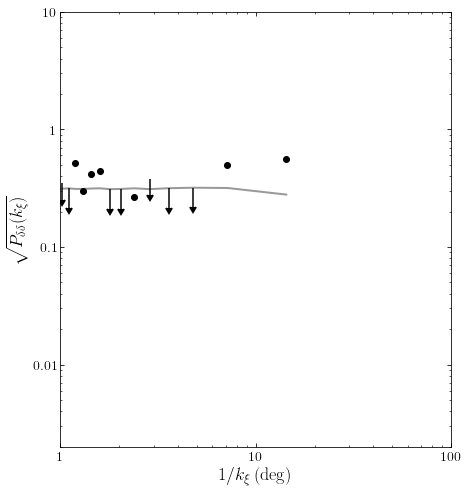

In [40]:
def plot_dens_data(color=sns.color_palette()[0],zorder=10,marker='o',
                   poly_deg=3,minxi=0.25,
                   errsim_color=sns.color_palette()[2],errsim_zorder=0,
                   err_color=0.7,err_zorder=0,err=False):
    """Plots the power spectrum of the data"""
    # Read the data
    backg= 400.
    data= numpy.loadtxt('../data/ibata_fig7b_raw.dat',delimiter=',')
    sindx= numpy.argsort(data[:,0])
    data= data[sindx]
    data_lowerr= numpy.loadtxt('../data/ibata_fig7b_rawlowerr.dat',delimiter=',')
    sindx= numpy.argsort(data_lowerr[:,0])
    data_lowerr= data_lowerr[sindx]
    data_uperr= numpy.loadtxt('../data/ibata_fig7b_rawuperr.dat',delimiter=',')
    sindx= numpy.argsort(data_uperr[:,0])
    data_uperr= data_uperr[sindx]
    data_err= 0.5*(data_uperr-data_lowerr)
    # CUTS
    indx= (data[:,0] > minxi-0.05)*(data[:,0] < 14.35)
    data= data[indx]
    data_lowerr= data_lowerr[indx]
    data_uperr= data_uperr[indx]
    data_err= data_err[indx]
    # Compute power spectrum
    tdata= data[:,1]-backg
    pp= Polynomial.fit(data[:,0],tdata,deg=poly_deg,w=1./data_err[:,1])
    tdata/= pp(data[:,0])
    data_err= data_err[:,1]/pp(data[:,0])
    ll= data[:,0]
    px, py= signal.csd(tdata,tdata,
                        fs=1./(ll[1]-ll[0]),scaling=scaling,
                        nperseg=len(ll))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(ll[-1]-ll[0]))
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err= numpy.empty((nerrsim,len(px)))
    for ii in range(nerrsim):
        tmock= data_err*numpy.random.normal(size=len(ll))
        ppy_err[ii]= signal.csd(tmock,tmock,
                                fs=1./(ll[1]-ll[0]),scaling=scaling,
                                nperseg=len(ll))[1].real
    py_err= numpy.sqrt(numpy.median(ppy_err,axis=0)*(ll[-1]-ll[0]))
    pcut= 0.4 # Only trust points above this, then remove noise
    loglog(px[py>pcut],numpy.sqrt(py[py>pcut]**2.-py_err[py>pcut]**2.),
           marker=marker,color=color,zorder=zorder,ls='none')
    errorbar(px[(py<pcut)],numpy.amax(numpy.array([py,py_err]),axis=0)[py<pcut],
             yerr=numpy.array([.1+0.*px[(py<pcut)],.1+0.*px[(py<pcut)]]),
             uplims=True,capthick=2.,ls='none',color=color,zorder=zorder)
    loglog(px,py_err,lw=2.,color=errsim_color,zorder=errsim_zorder)
    return None

scaling = 'spectrum'
plot_dens_data(color='k',zorder=20,poly_deg=3,minxi=0.65,errsim_color='0.6')
set_ranges_and_labels_dens()

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply



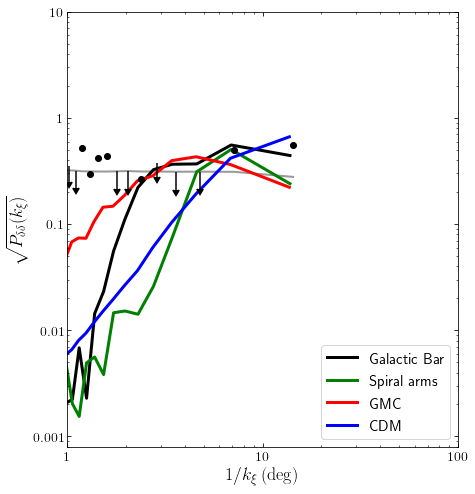

In [45]:
fname0='../sampled_SCFbar/1010Msun_39patspeed_streamdf/Pal5_5M_density_botharms_streamdf_5Gyr_39patspeed.dat'
px0,py0,pyerr0=compute_Pk(fname0, scaling = 'spectrum')

fname4='../sampled_spiral/spiralN4_19.5patspeed_FR1.0_3Gyr_streamdf/Pal5_density_5M_botharms_spiralN4_19.5patspeed_FR1.0_3Gyr_streamdf_poly3norm.dat'
px4,py4,pyerr4=compute_Pk(fname4, scaling = 'spectrum')


bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,8)

loglog(px0,py0,color='k',lw=3,zorder=1,label=r'Galactic Bar')
loglog(px4,py4,color='g',lw=3,zorder=1,label=r'Spiral arms')
plot_pk_scatter('molecular_clouds/dens_combined/dens_MCMmin105_rand_rotate_impact_Pal5_4096_on_128_Plummer_poly3norm_',N=42,fill=False,color='r',label=r'GMC')
loglog(Px,Ppy,color='b',lw=3,zorder=1,label=r'CDM')
plot_dens_data(color='k',zorder=20,poly_deg=3,minxi=0.65,errsim_color='0.6')


#loglog(px0,pyerr0,color='g',zorder=1,ls='--')

legend(loc='lower right',fontsize=15)
set_ranges_and_labels_dens()
savefig('plots/final_plot_Pal5data.pdf')